In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick

import matplotlib.lines
from pathlib import Path
import fastq as fq
import tqdm
import re
import sys
import seaborn as sns
import scipy.stats
import os
import msprime
import pysam

# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools


In [3]:
sys.path.append("/nfs/users/nfs_r/rs42/rs42/git/hapfusion/src")
sys.path.append("/nfs/users/nfs_r/rs42/rs42/git/himut/src")

sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover
from src import annotate_old as annotate

In [4]:
import hapfusion
import himut

# Which samples?

In [5]:
aut_chrom_names = [f"chr{i}" for i in list(range(1, 23))]
chrom_names = aut_chrom_names + ["chrX", "chrY"]

In [6]:
sample_ids = [
    "PD50477f",
    # "PD50508bf", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD50519d",
    # "PD47269d", -- don't use, not there
    "PD50508f",
    # "PD50511e", -- don't use, likely mixture
    "PD50523b",
    # "PD48473b", -- don't use, not there
    "PD50521b",
    "PD50508b",
    # "PD50521be", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD46180c",
    # "PD50502f", -- don't use, likely mixture
    "PD50521e",
    # "PD50511e_SS",  --- don't use
    "PD50489e",
]

# Functions to load _hapfusion_ summary files

## Loading files using T2T as reference

In [7]:
t2t_hapfusion_output_path = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/03.T2T-CHM13")

def t2t_load_files(sample_id):
    data_path = t2t_hapfusion_output_path / sample_id

    reads_df = pd.read_csv(
        str(data_path / f"chm13.{sample_id}.hapfusion.txt"),
        comment="#",
        delim_whitespace=True,
        header=None,
    )

    log_df = pd.read_csv(
        str(data_path / "hapfusion.log"),
        delim_whitespace=True,
        index_col=0,
    )

    candidates_df = pd.read_csv(
        str(data_path / "hapfusion_candidates.txt"),
        delim_whitespace=True,
    )

    return {"reads": reads_df, "summary": log_df, "candidates": candidates_df}



## Loading files using hg19 as reference

In [8]:
hg19_hapfusion_output_path = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/01.grch37")

def hg19_load_files(sample_id):
    data_path = hg19_hapfusion_output_path / sample_id

    reads_df = pd.read_csv(
        str(data_path / f"hg19.{sample_id}.hapfusion.txt"),
        comment="#",
        delim_whitespace=True,
        header=None,
    )

    log_df = pd.read_csv(
        str(data_path / "hapfusion.log"),
        delim_whitespace=True,
        index_col=0,
    )

    candidates_df = pd.read_csv(
        str(data_path / "hapfusion_candidates.txt"),
        delim_whitespace=True,
    )

    return {"reads": reads_df, "summary": log_df, "candidates": candidates_df}



## Loading files using de-novo assembly as reference

In [9]:
denovo_hapfusion_output_path = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds")

def denovo_load_files(sample_id):
    data_path = denovo_hapfusion_output_path / sample_id
    if not (data_path / f"{sample_id}.hapfusion.txt").exists():
        data_path = denovo_hapfusion_output_path / sample_id / sample_id

    reads_df = pd.read_csv(
        str(data_path / f"{sample_id}.hapfusion.txt"),
        comment="#",
        delim_whitespace=True,
    )

    log_df = pd.read_csv(
        str(data_path / "hapfusion.log"),
        delim_whitespace=True,
        index_col=0,
    )

    candidates_df = pd.read_csv(
        str(data_path / "hapfusion_candidates.txt"),
        delim_whitespace=True,
    )

    return {"reads": reads_df, "summary": log_df, "candidates": candidates_df}





In [10]:
F = denovo_load_files("PD50523b")

In [11]:
F["summary"]

,chr1_RagTag,chr2_RagTag,chr3_RagTag,chr4_RagTag,chr5_RagTag,chr6_RagTag,chr7_RagTag,chr8_RagTag,chr9_RagTag,chr10_RagTag,...,chr16_RagTag,chr17_RagTag,chr18_RagTag,chr19_RagTag,chr20_RagTag,chr21_RagTag,chr22_RagTag,chrX_RagTag,chrY_RagTag,total
ccs,277803,299310,251738,246879,229346,213169,196196,189668,147025,166608,...,98521,85252,106128,50554,75084,48788,51109,8445,9376,3437343
lq_ccs,19737,18207,14262,13673,13365,11925,11982,11333,11308,9976,...,12585,5340,7027,4104,4785,5307,7887,670,6192,238970
hq_ccs,258066,281103,237476,233206,215981,201244,184214,178335,135717,156632,...,85936,79912,99101,46450,70299,43481,43222,7775,3184,3198373
unphased_ccs,45152,50681,41361,37862,36231,35397,28498,31038,23266,25642,...,15190,13559,14873,8380,11033,7169,6380,454,948,538236
hap_consistent_ccs,202524,218783,186610,184981,170658,157482,147537,139768,106899,124125,...,66987,63136,79647,36171,56157,34257,34589,5927,2045,2522586
hap_inconsistent_ccs,10390,11639,9505,10363,9092,8365,8179,7529,5552,6865,...,3759,3217,4581,1899,3109,2055,2253,1394,191,137551
hap_denovo_phase_switch_mutation_ccs,9911,11301,9161,10287,8818,8094,7898,7416,5376,6653,...,3672,3091,4424,1814,2961,2102,2366,1885,237,134089
hap_recombination_candidate_ccs,1767,1826,1504,1651,1550,1328,1350,1227,893,1131,...,625,546,787,301,499,359,419,207,38,22551
ambiguous,278,307,222,293,314,239,257,233,147,208,...,117,105,169,44,94,82,105,51,18,4129
crossover,12,17,10,10,11,15,6,8,8,7,...,5,7,13,5,2,4,6,1,2,184


# Calculate expected # of crossovers

## Get read lengths and number (precalculated)

In [12]:
read_length_means = {}
read_length_stds = {}
read_numbers = {}

ccs_read_path = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/02.ccs/")

for sample_id in sample_ids:
    count_path = ccs_read_path / sample_id / (sample_id + ".ccs.filtered.fastqc")
    d = open(count_path).read().strip().split()
    read_numbers[sample_id] = int(d[1])
    read_length_means[sample_id] = float(d[3])
    read_length_stds[sample_id] = float(d[4])

## Calculate

In [13]:
def plot_obs_vs_exp(df):
    qs = scipy.stats.binom(n=df.n_reads, p=df.prob_crossover_read).ppf(np.array([0.25, 1-0.25])[:, np.newaxis])

    fig, ax = plt.subplots()
    ax.errorbar(        
        x = df.n_expected_mean,
        y = np.arange(len(df)),
        xerr = [df.n_expected_mean - qs[0], qs[1] - df.n_expected_mean],
        fmt='o',
    )

    ax.scatter(        
        df.n_observed,
        np.arange(len(df)),
        c = "C1",
    )

    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df.sample_id)
    ax.set_ylabel("Sample ID")
    ax.set_xlabel("# of crossover events")
    ax.set_xlim(0, 800)

    for i in range(len(df)):
        ax.axhline(y = i, lw=0.05, c="black")

    return ax 

In [14]:
num_events_mean = 27
num_events_low = 20
num_events_high = 36

genome_size = 3.1e9

### For T2T

In [15]:
res = []

for sample_id in sample_ids:
    try:
        total_series = t2t_load_files(sample_id)["summary"]["total"]
        n_reads = total_series.loc["ccs"]
        n_obs = total_series.loc["crossover"]
        read_length_mean = read_length_means[sample_id]
        prob = (num_events_mean * read_length_mean / genome_size)

        res.append([
            sample_id,
            n_obs,
            n_reads * prob,
            n_reads, 
            prob,
            scipy.stats.binom.logcdf(k=n_obs, n=n_reads, p=prob),
            scipy.stats.binom.logsf(k=n_obs, n=n_reads, p=prob),
        ])
    except:
        pass

t2t_exp_df = pd.DataFrame(res, columns=["sample_id", "n_observed", "n_expected_mean", "n_reads", "prob_crossover_read", "logcdf", "logsf"])

Text(0.5, 1.0, 'T2T reference')

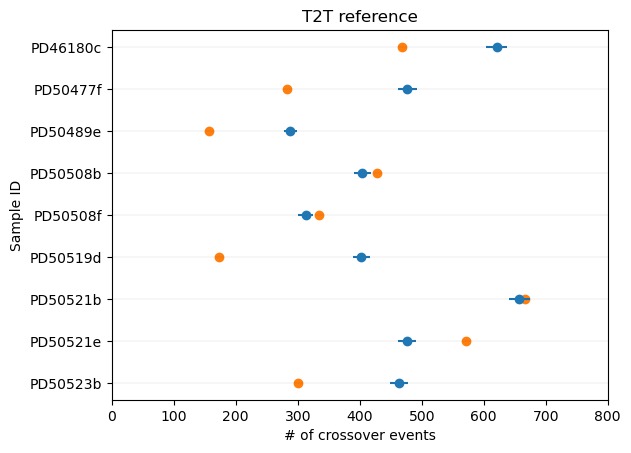

In [16]:
plot_obs_vs_exp(t2t_exp_df.sort_values("sample_id", ascending=False)).set_title("T2T reference")

### For hg19

In [17]:
res = []

for sample_id in sample_ids:
    try:
        total_series = hg19_load_files(sample_id)["summary"]["total"]
        n_reads = total_series.loc["ccs"]
        n_obs = total_series.loc["crossover"]
        read_length_mean = read_length_means[sample_id]
        prob = (num_events_mean * read_length_mean / genome_size)

        res.append([
            sample_id,
            n_obs,
            n_reads * prob,
            n_reads, 
            prob,
            scipy.stats.binom.logcdf(k=n_obs, n=n_reads, p=prob),
            scipy.stats.binom.logsf(k=n_obs, n=n_reads, p=prob),
        ])
    except:
        pass

hg19_exp_df = pd.DataFrame(res, columns=["sample_id", "n_observed", "n_expected_mean", "n_reads", "prob_crossover_read", "logcdf", "logsf"])

Text(0.5, 1.0, 'hg19 reference')

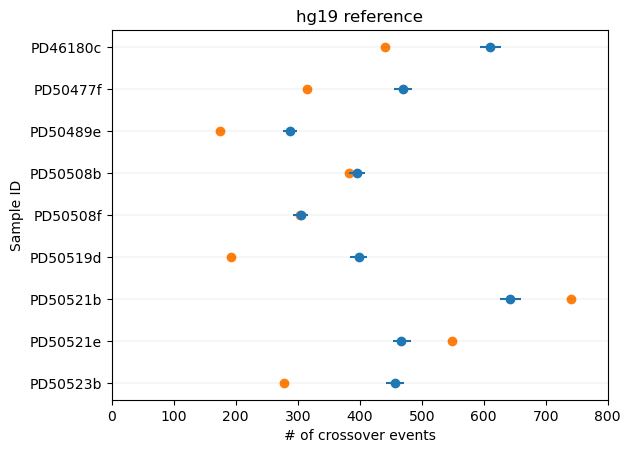

In [18]:
plot_obs_vs_exp(hg19_exp_df.sort_values("sample_id", ascending=False)).set_title("hg19 reference")

### For denovo

In [19]:
res = []

for sample_id in sample_ids:
    try:
        total_series = denovo_load_files(sample_id)["summary"]["total"]
        n_reads = total_series.loc["ccs"]
        n_obs = total_series.loc["crossover"]
        read_length_mean = read_length_means[sample_id]
        prob = (num_events_mean * read_length_mean / genome_size)

        res.append([
            sample_id,
            n_obs,
            n_reads * prob,
            n_reads, 
            prob,
            scipy.stats.binom.logcdf(k=n_obs, n=n_reads, p=prob),
            scipy.stats.binom.logsf(k=n_obs, n=n_reads, p=prob),
        ])
    except:
        pass

denovo_exp_df = pd.DataFrame(res, columns=["sample_id", "n_observed", "n_expected_mean", "n_reads", "prob_crossover_read", "logcdf", "logsf"])

Text(0.5, 1.0, 'hifiasm reference')

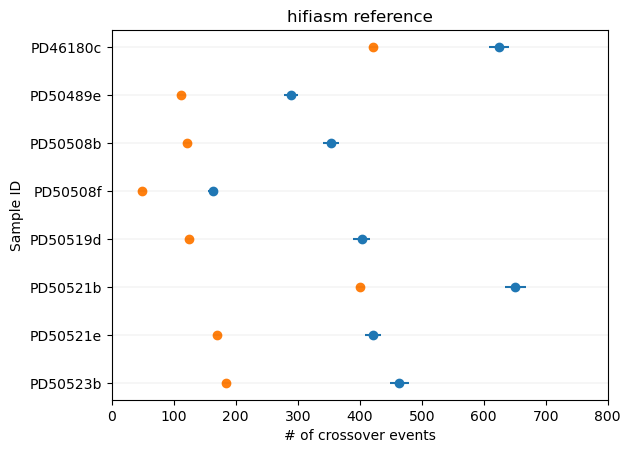

In [20]:
plot_obs_vs_exp(denovo_exp_df.sort_values("sample_id", ascending=False)).set_title("hifiasm reference")

# Crossovers on sex chromosomes

In [21]:
res = []

for sample_id in sample_ids:
    row = []
    row.append(sample_id)

    # T2T
    try:
        summary = t2t_load_files(sample_id)["summary"]
        row.append(int(summary["chrX"].loc["crossover"]))
        row.append(int(summary["chrY"].loc["crossover"]))
    except:
        row.extend([pd.NA, pd.N])

    # hg19
    try:
        summary = hg19_load_files(sample_id)["summary"]
        row.append(int(summary["X"].loc["crossover"]))
        row.append(int(summary["Y"].loc["crossover"]))
    except:
        row.extend([pd.NA, pd.N])

    # Denovo
    try:
        summary = denovo_load_files(sample_id)["summary"]
        row.append(int(summary["chrX_RagTag"].loc["crossover"]))
        row.append(int(summary["chrY_RagTag"].loc["crossover"]))
    except:
        row.extend([pd.NA, pd.NA])

    res.append(row)

sex_df = pd.DataFrame(res, columns=["sample_id", "t2t_X", "t2t_Y", "hg19_X", "hg19_Y", "denovo_X", "denovo_Y"])


In [22]:
sex_df.sort_values("sample_id")

,sample_id,t2t_X,t2t_Y,hg19_X,hg19_Y,denovo_X,denovo_Y
6,PD46180c,0,0,1,1,0,6
0,PD50477f,1,0,0,0,<NA>,<NA>
8,PD50489e,0,0,2,0,0,3
5,PD50508b,4,1,4,1,0,0
2,PD50508f,3,1,9,0,1,1
1,PD50519d,0,0,0,0,0,2
4,PD50521b,0,4,5,13,3,14
7,PD50521e,0,1,1,12,<NA>,<NA>
3,PD50523b,0,2,0,0,1,2


# Count GCs

In [23]:
summary

,chr1_RagTag,chr2_RagTag,chr3_RagTag,chr4_RagTag,chr5_RagTag,chr6_RagTag,chr7_RagTag,chr8_RagTag,chr9_RagTag,chr10_RagTag,...,chr16_RagTag,chr17_RagTag,chr18_RagTag,chr19_RagTag,chr20_RagTag,chr21_RagTag,chr22_RagTag,chrX_RagTag,chrY_RagTag,total
ccs,244581,263575,226662,213264,209615,190160,167045,167980,131913,151586,...,75490,65582,94288,37535,67479,48154,45403,7346,6327,3011062
lq_ccs,18285,17346,14641,13628,13414,11965,11541,11354,11270,10449,...,7578,4762,6017,2924,4429,5968,6434,526,2413,220981
hq_ccs,226296,246229,212021,199636,196201,178195,155504,156626,120643,141137,...,67912,60820,88271,34611,63050,42186,38969,6820,3914,2790081
unphased_ccs,45224,50843,42144,39981,38988,35109,30790,30316,23066,26615,...,13263,11909,15853,6095,12342,7767,7106,354,623,547147
hap_consistent_ccs,174314,188442,163823,153850,151605,137844,120214,121515,94132,110059,...,52343,47017,69736,27372,48831,32899,30358,5648,2484,2158800
hap_inconsistent_ccs,6758,6944,6054,5805,5608,5242,4500,4795,3445,4463,...,2306,1894,2682,1144,1877,1520,1505,818,807,84134
hap_denovo_phase_switch_mutation_ccs,6313,6346,5515,5504,5063,4808,4037,4525,2988,4136,...,2233,1723,2436,1209,1783,1343,1707,1013,3666,81027
hap_recombination_candidate_ccs,1307,1354,1219,1188,1114,1048,883,898,743,899,...,379,371,544,272,347,387,337,169,472,17051
ambiguous,215,207,153,205,195,185,149,155,104,147,...,55,80,103,58,54,91,99,41,219,3059
crossover,10,7,14,7,6,5,3,5,6,2,...,2,7,6,0,3,3,3,0,3,112


In [24]:
res = []

for sample_id in sample_ids:
    row = []
    row.append(sample_id)

    # T2T
    try:
        summary = t2t_load_files(sample_id)["summary"]
        row.append(int(summary["total"].loc["simple_gene_conversion"]))
        row.append(int(summary["total"].loc["complex_gene_conversion"]))
    except:
        row.extend([np.nan, np.nan])

    # hg19
    try:
        summary = hg19_load_files(sample_id)["summary"]
        row.append(int(summary["total"].loc["simple_gene_conversion"]))
        row.append(int(summary["total"].loc["complex_gene_conversion"]))
    except:
        row.extend([np.nan, np.nan])

    # Denovo
    try:
        summary = denovo_load_files(sample_id)["summary"]
        row.append(int(summary["total"].loc["simple_gene_conversion"]))
        row.append(int(summary["total"].loc["complex_gene_conversion"]))
    except:
        row.extend([np.nan, np.nan])

    res.append(row)

gc_df = pd.DataFrame(res, columns=["sample_id", "t2t_GC_simple", "t2t_GC_complex", "hg19_GC_simple", "hg19_GC_complex", "denovo_GC_simple", "denovo_GC_complex"])


In [25]:
gc_df

,sample_id,t2t_GC_simple,t2t_GC_complex,hg19_GC_simple,hg19_GC_complex,denovo_GC_simple,denovo_GC_complex
0,PD50477f,1214,3945,1167,11243,NaN,NaN
1,PD50519d,938,3210,972,9342,970.0,2199.0
2,PD50508f,1181,6439,1129,10523,230.0,611.0
3,PD50523b,1392,3821,1365,10055,1414.0,2425.0
4,PD50521b,1313,13443,1375,22863,1417.0,7258.0
5,PD50508b,1703,7221,1671,12175,873.0,1455.0
6,PD46180c,1440,7794,1343,14646,1482.0,6345.0
7,PD50521e,1742,8328,1647,15935,1210.0,2117.0
8,PD50489e,793,1718,788,9552,835.0,1596.0


# Check if crossovers are consistent

In [26]:
rate_maps = {}
for chrom in aut_chrom_names:
    rate_maps[chrom] = \
        msprime.RateMap.read_hapmap(
            open(f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/07.references/04.genetic_maps/02.T2T_lifted_Bherer_etal_SexualDimorphismRecombination/Refined_EUR_genetic_map_b37/male_{chrom}_genetic_map.txt"),
            sequence_length=liftover.T2T_chromosome_sizes_in_bp[chrom],
        )

In [27]:
# Parse the reads dataframe and add the intersection with the lifted accessibility mask
def extend_reads_df(reads_df):
    reads_df["read_chrom"] = reads_df[0].str.split(':').str[0]
    reads_df["read_start_pos_0based"] = reads_df[0].str.split(':').str[1].str.split('-').str[0].astype(int)
    reads_df["read_end_pos_0based"] = reads_df[0].str.split(':').str[1].str.split('-').str[1].astype(int)

    return annotate.annonate_with_mappability_mask(reads_df)


In [28]:
def get_cm_ranges(sample_id):
    reads_df = t2t_load_files(sample_id)["reads"]
    reads_df = extend_reads_df(reads_df)

    dfs = []
    cms = []
    
    for chrom in aut_chrom_names:
        print(chrom)
        rate_map = rate_maps[chrom]

        crossovers_df = reads_df[reads_df[0].str.startswith(f"{chrom}:") & (reads_df[4] == "CO")]
        dfs.append(crossovers_df)

        range_col = crossovers_df[0].str.split(':').str[1]
        start_poses_0based = range_col.str.split('-').str[0].astype(int) - 1
        end_poses_0based = range_col.str.split('-').str[1].astype(int)                
        start_poses_cm = rate_map.get_cumulative_mass(start_poses_0based.values)
        end_poses_cm = rate_map.get_cumulative_mass(end_poses_0based.values)
        cms.append((end_poses_cm - start_poses_cm) * 1e6)

        #return crossovers_df

    return dfs, cms
    
dfs, cms = get_cm_ranges(sample_id)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22


In [29]:
df = pd.concat(dfs)

In [30]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    display(df[[0, 1, 4, "accessible_ratio"]])

,0,1,4,accessible_ratio
153,chr1:16406144-16429403,m64174e_220620_110709/52561002/ccs,CO,0.000000
155,chr1:16413025-16428274,m64094e_220715_151527/47186949/ccs,CO,0.000000
168,chr1:16424618-16445834,m64174e_220620_110709/14944360/ccs,CO,0.000000
169,chr1:16426051-16440322,m64094e_220717_002414/120261263/ccs,CO,0.000000
170,chr1:16426313-16435589,m64174e_220620_110709/49219956/ccs,CO,0.000000
339,chr1:57184965-57206053,m64094e_220715_151527/84804594/ccs,CO,0.998008
385,chr1:65453916-65470676,m64174e_220620_110709/1704631/ccs,CO,0.998866
510,chr1:86319215-86332066,m64174e_220620_110709/56165494/ccs,CO,0.999300
716,chr1:120841578-120848318,m64094e_220717_002414/38142195/ccs,CO,0.000000
737,chr1:127494582-127500034,m64174e_220620_110709/141560164/ccs,CO,0.296588


# How many reads were mapped?

In [31]:
sample_id = sample_ids[0]
print(sample_id)                       

PD50477f


In [32]:
total_read_numbers = {}   # Different than from the fastqc for some reason - this will be taken from the bam
mapped_read_numbers = {}
for sample_id in sample_ids:
    mapped_read_numbers[sample_id] = 0
    
    F = pysam.AlignmentFile(
        f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/03.T2T-CHM13/{sample_id}/chm13.{sample_id}.minimap2.primary_alignments.sorted.bam"
    )

    total_read_numbers[sample_id] = F.nocoordinate
    all_index_stats = F.get_index_statistics()

    for index_stats in all_index_stats:
        total_read_numbers[sample_id] += index_stats.total
        if index_stats.contig in chrom_names:
            mapped_read_numbers[sample_id] += index_stats.mapped


In [33]:
read_number_stats_df = pd.DataFrame(
    {
        "sample_id": sample_ids,
        "n_all_reads": [total_read_numbers[sample_id] for sample_id in sample_ids],
        "n_mapped_reads": [mapped_read_numbers[sample_id] for sample_id in sample_ids],
    }
)

read_number_stats_df = read_number_stats_df.merge(
    t2t_exp_df[["sample_id", "n_reads"]].rename(columns={"n_reads": "n_hapfusion_reads"})
)

read_number_stats_df["mapped_to_all_ratio"] = read_number_stats_df["n_mapped_reads"] / read_number_stats_df["n_all_reads"]
read_number_stats_df["hapfusion_to_mapped_ratio"] = read_number_stats_df["n_hapfusion_reads"] / read_number_stats_df["n_mapped_reads"]


display(read_number_stats_df)

,sample_id,n_all_reads,n_mapped_reads,n_hapfusion_reads,mapped_to_all_ratio,hapfusion_to_mapped_ratio
0,PD50477f,7185241,5671375,4066022,0.789309,0.716938
1,PD50519d,5353906,4971177,3288910,0.928514,0.661596
2,PD50508f,3040994,2778593,2109867,0.913712,0.759329
3,PD50523b,4741878,4740213,3429042,0.999649,0.723394
4,PD50521b,6294384,6293834,4765229,0.999913,0.757127
5,PD50508b,3947659,3947252,2958538,0.999897,0.749518
6,PD46180c,5936129,5819160,4351397,0.980295,0.747771
7,PD50521e,6168195,6125876,4466513,0.993139,0.729122
8,PD50489e,6065965,6064631,3003323,0.999780,0.495219


In [34]:
display(read_number_stats_df[["sample_id", "n_all_reads", "n_mapped_reads", "mapped_to_all_ratio"]])

,sample_id,n_all_reads,n_mapped_reads,mapped_to_all_ratio
0,PD50477f,7185241,5671375,0.789309
1,PD50519d,5353906,4971177,0.928514
2,PD50508f,3040994,2778593,0.913712
3,PD50523b,4741878,4740213,0.999649
4,PD50521b,6294384,6293834,0.999913
5,PD50508b,3947659,3947252,0.999897
6,PD46180c,5936129,5819160,0.980295
7,PD50521e,6168195,6125876,0.993139
8,PD50489e,6065965,6064631,0.999780


In [35]:
X = pysam.AlignmentFile(
        f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/03.T2T-CHM13/PD50477f/chm13.PD50477f.minimap2.primary_alignments.sorted.bam"
)

In [36]:
t2t_access_mask = pybedtools.BedTool("/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/07.references/05.accessibility_masks/01.T2T/combined_mask.bed.gz")

In [37]:
reads_df = pd.DataFrame(
    [[segment.reference_name, segment.reference_start, segment.reference_end] for segment in X.fetch("chr1")],
    columns=["read_chrom", "read_start_pos_1based", "read_end_pos_1based"]
)

reads_df["read_start_pos_0based"] = reads_df["read_start_pos_1based"] - 1
reads_df["read_end_pos_0based"] = reads_df["read_end_pos_1based"]
reads_df = reads_df.drop(columns=["read_start_pos_1based", "read_end_pos_1based"])

reads_df = reads_df.sample(frac=0.1)

reads_bed = pybedtools.BedTool.from_dataframe(reads_df)

In [38]:
intersection_df = (t2t_access_mask
    .intersect(reads_bed, wb=True)
    .to_dataframe()
    .set_axis(["chrom", "start", "end", "read_chrom", "read_start_pos_0based", "read_end_pos_0based"], axis=1)
)

intersection_df = (intersection_df
    .assign(interval_length = lambda df: df["end"] - df["start"])
    .groupby(by=["read_chrom", "read_start_pos_0based", "read_end_pos_0based"])[["interval_length"]]
    .sum()
    .reset_index()        
    .merge(reads_df, on=["read_chrom", "read_start_pos_0based", "read_end_pos_0based"], how="right")
    .fillna({"interval_length": 0})
    .assign(read_length = lambda df: df["read_end_pos_0based"] - df["read_start_pos_0based"])
    .assign(accessible_ratio = lambda df: df["interval_length"] / df["read_length"].astype(float))   
)

In [39]:
intersection_df

,read_chrom,read_start_pos_0based,read_end_pos_0based,interval_length,read_length,accessible_ratio
0,chr1,145746673,145762950,1227.0,16277,0.075382
1,chr1,110028676,110046896,17307.0,18220,0.949890
2,chr1,132608649,132624862,0.0,16213,0.000000
3,chr1,222030989,222045167,14065.0,14178,0.992030
4,chr1,85899251,85910020,10743.0,10769,0.997586
...,...,...,...,...,...,...
47887,chr1,219164486,219176959,11864.0,12473,0.951175
47888,chr1,157062570,157072705,10023.0,10135,0.988949
47889,chr1,188943382,188955388,12004.0,12006,0.999833
47890,chr1,49061730,49075873,14142.0,14143,0.999929


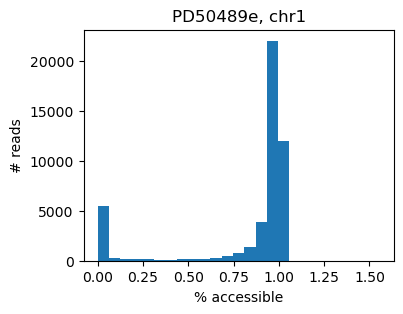

In [40]:
fig, ax = plt.subplots(figsize=(4,3))
ax.hist(
    intersection_df.accessible_ratio,
    bins=25,    
);
ax.set_xlabel("% accessible");
ax.set_ylabel("# reads")
ax.set_title(f"{sample_id}, chr1");

In [41]:
(intersection_df.accessible_ratio>0.5).mean()

0.8621064060803475

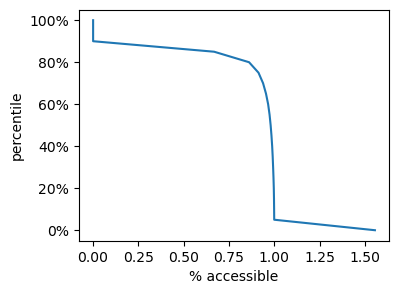

In [42]:
fig, ax = plt.subplots(figsize=(4,3))
qs = np.linspace(0, 100, 21)
ys = np.percentile(intersection_df.accessible_ratio, q=qs)
ax.plot(ys, 100-qs)
ax.set_xlabel("% accessible")
ax.set_ylabel("percentile")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())


# Annotate interval with recombination probability, and detectability

In [43]:
%%time
def annotate_intervals(
    sample_id,
    chrom,
    starts_0based, 
    ends_0based,
):
    # Bed of all intervals
    reads_df = \
        pd.DataFrame({
            "sample_id": sample_id,
            "read_chrom": chrom,
            "read_start_pos_0based":starts_0based,
            "read_end_pos_0based": ends_0based,
        })

    # Add annotations
    reads_df = annotate.annonate_with_mappability_mask(reads_df)
    reads_df = annotate.annotate_with_cm_ranges(reads_df) 
    reads_df = annotate.annotate_with_crossover_detection_prob(
        reads_df,
        annotate.get_all_hets(sample_id, chrom)
    )   

    return reads_df

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.01 µs


## What is the random distribution of cMs?

In [44]:
%%time

rng = np.random.default_rng()

sample_id = "PD46180c"
chrom = "chr1"
n_fake_reads = 10000
fake_read_length = int(read_length_means[sample_id])

# Create random positions
random_positions = rng.integers(low = 0, high = liftover.T2T_chromosome_sizes_in_bp[chrom], size = n_fake_reads)

# Remove if too close to the edge
random_positions = random_positions[random_positions + fake_read_length < liftover.T2T_chromosome_sizes_in_bp[chrom]]

fake_reads_df = annotate_intervals(
    sample_id,
    chrom,
    starts_0based = random_positions, 
    ends_0based = random_positions + fake_read_length,
)
    
fake_reads_df

CPU times: user 1.71 s, sys: 175 ms, total: 1.88 s
Wall time: 4.84 s


,read_chrom,read_start_pos_0based,read_end_pos_0based,snp_pos_0based_min,snp_pos_0based_max,interval_length,sample_id,read_length,accessible_ratio,cM,prob_crossover,phased_snps_span,crossover_detection_prob
0,chr1,176706572,176722952,176707160.0,176722445.0,16274.0,PD46180c,16380,0.993529,0.006914,0.000069,15285.0,0.933150
1,chr1,215294261,215310641,NaN,NaN,16266.0,PD46180c,16380,0.993040,0.016128,0.000161,NaN,0.000000
2,chr1,158318459,158334839,158319136.0,158328124.0,16345.0,PD46180c,16380,0.997863,0.019149,0.000191,8988.0,0.548718
3,chr1,61219442,61235822,NaN,NaN,16355.0,PD46180c,16380,0.998474,0.000430,0.000004,NaN,0.000000
4,chr1,152222033,152238413,152225570.0,152231661.0,15759.0,PD46180c,16380,0.962088,0.046132,0.000461,6091.0,0.371856
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,chr1,46479711,46496091,46479910.0,46494066.0,14199.0,PD46180c,16380,0.866850,0.015943,0.000159,14156.0,0.864225
9996,chr1,237246106,237262486,237254312.0,237262395.0,16357.0,PD46180c,16380,0.998596,0.046483,0.000465,8083.0,0.493468
9997,chr1,131618194,131634574,NaN,NaN,0.0,PD46180c,16380,0.000000,0.000000,0.000000,NaN,0.000000
9998,chr1,181669697,181686077,181670559.0,181684803.0,15636.0,PD46180c,16380,0.954579,0.036430,0.000364,14244.0,0.869597


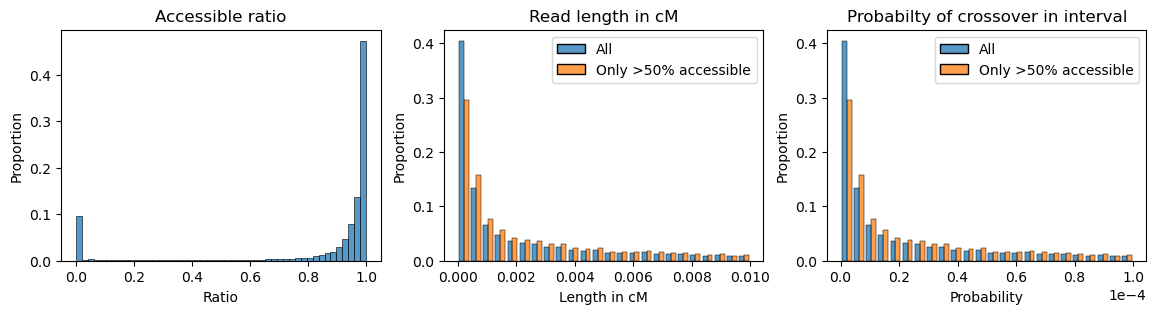

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))

sns.histplot(
    fake_reads_df["accessible_ratio"],
    bins=np.linspace(0, 1, 50),
    stat="proportion",
    ax=axs[0],
)
axs[0].set_title("Accessible ratio");
axs[0].set_xlabel("Ratio");

sns.histplot(
    [
        pd.Series(fake_reads_df["cM"].values, name="All"),
        pd.Series(fake_reads_df["cM"][fake_reads_df["accessible_ratio"]>0.5].values, name="Only >50% accessible"),
    ],
    bins=np.linspace(0, 0.01, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=axs[1],
)
axs[1].set_title("Read length in cM");
axs[1].set_xlabel("Length in cM");

sns.histplot(
    [
        pd.Series(fake_reads_df["prob_crossover"].values, name="All"),
        pd.Series(fake_reads_df["prob_crossover"][fake_reads_df["accessible_ratio"]>0.5].values, name="Only >50% accessible"),
    ], 
    bins=np.linspace(0, 1e-4, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=axs[2],
)

axs[2].set_title("Probabilty of crossover in interval");
axs[2].set_xlabel("Probability");
axs[2].ticklabel_format(axis="x", style="sci", scilimits=(0,0))


## Are random reads distributed differently than crossosver calls?

In [46]:
sample_id = "PD46180c"

F = t2t_load_files(sample_id)

In [47]:
%%time
true_reads_df = extend_reads_df(F["reads"])

CPU times: user 1.18 s, sys: 156 ms, total: 1.33 s
Wall time: 5.74 s


In [48]:
subset_true_reads_df = true_reads_df[(true_reads_df.read_chrom == chrom) & (true_reads_df[4] == "CO")]

In [49]:
true_reads_chrom_df = annotate_intervals(
    sample_id,
    chrom,
    starts_0based = subset_true_reads_df["read_start_pos_0based"], 
    ends_0based = subset_true_reads_df["read_end_pos_0based"],
)

true_reads_chrom_df["read_name"] = subset_true_reads_df[1].values

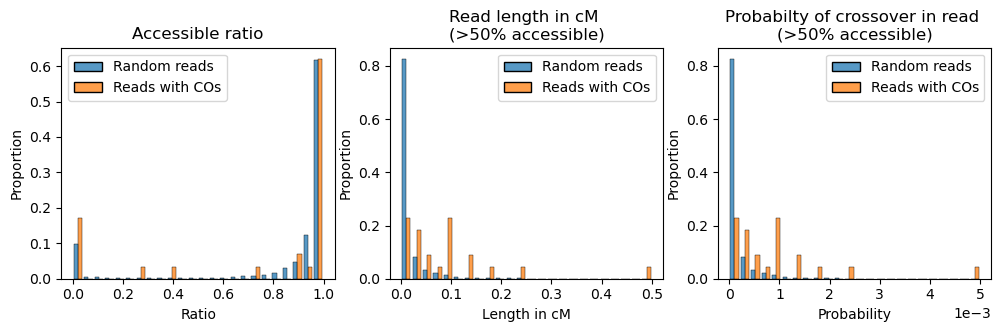

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

sns.histplot(
    [
        pd.Series(fake_reads_df["accessible_ratio"].values, name="Random reads"),
        pd.Series(true_reads_chrom_df["accessible_ratio"].values, name="Reads with COs"),
    ]
    ,
    bins=np.linspace(0, 1, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=axs[0],
)
axs[0].set_title("Accessible ratio");
axs[0].set_xlabel("Ratio");

sns.histplot(
    [
        pd.Series(fake_reads_df["cM"][fake_reads_df["accessible_ratio"]>0.5].values, name="Random reads"),
        pd.Series(true_reads_chrom_df["cM"][true_reads_chrom_df["accessible_ratio"]>0.5].values, name="Reads with COs"),
    ],
    bins=np.linspace(0, 0.5, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=axs[1],
)
axs[1].set_title("Read length in cM \n(>50% accessible)");
axs[1].set_xlabel("Length in cM");

sns.histplot(
    [
        pd.Series(fake_reads_df["prob_crossover"][fake_reads_df["accessible_ratio"]>0.5].values, name="Random reads"),
        pd.Series(true_reads_chrom_df["prob_crossover"][true_reads_chrom_df["accessible_ratio"]>0.5].values, name="Reads with COs"),
    ], 
    bins=np.linspace(0, 5e-3, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=axs[2],
)
axs[2].set_title("Probabilty of crossover in read \n(>50% accessible)");
axs[2].set_xlabel("Probability");
axs[2].ticklabel_format(axis="x", style="sci", scilimits=(0,0))


In [51]:
true_reads_chrom_df

,read_chrom,read_start_pos_0based,read_end_pos_0based,snp_pos_0based_min,snp_pos_0based_max,interval_length,sample_id,read_length,accessible_ratio,cM,prob_crossover,phased_snps_span,crossover_detection_prob,read_name
0,chr1,2136595,2151585,2142348,2151396,359.0,PD46180c,14990,0.023949,0.000000,0.000000,9048,0.603602,m64178e_220824_153720/75106227/ccs
1,chr1,3939600,3954737,3940507,3954597,15088.0,PD46180c,15137,0.996763,0.003559,0.000036,14090,0.930832,m64016e_220904_102424/68224737/ccs
2,chr1,4617436,4632864,4620898,4632594,14046.0,PD46180c,15428,0.910423,0.035557,0.000356,11696,0.758102,m64016e_220904_102424/36896782/ccs
3,chr1,7075632,7096841,7075792,7084559,18805.0,PD46180c,21209,0.886652,0.487502,0.004863,8767,0.413362,m64016e_220904_102424/56362294/ccs
4,chr1,19166890,19179783,19166996,19179471,9654.0,PD46180c,12893,0.748778,0.014837,0.000148,12475,0.967579,m64094e_220916_121850/89784760/ccs
5,chr1,30043909,30059477,30045104,30059282,15377.0,PD46180c,15568,0.987731,0.135494,0.001354,14178,0.910714,m64016e_220904_102424/45026050/ccs
6,chr1,30680621,30698544,30687867,30698357,17237.0,PD46180c,17923,0.961725,0.095301,0.000953,10490,0.585281,m64094e_220916_121850/177736500/ccs
7,chr1,74529236,74548147,74529971,74547999,18798.0,PD46180c,18911,0.994025,0.089463,0.000894,18028,0.953308,m64178e_220824_153720/115804034/ccs
8,chr1,77262009,77282852,77278624,77282848,20477.0,PD46180c,20843,0.982440,0.083540,0.000835,4224,0.202658,m64178e_220824_153720/86114340/ccs
9,chr1,94061357,94075537,94064406,94074318,14104.0,PD46180c,14180,0.994640,0.030075,0.000301,9912,0.699013,m64016e_220904_102424/111543741/ccs


In [52]:
true_reads_chrom_df["prob_crossover"][true_reads_chrom_df["accessible_ratio"]>0.5].values.mean()

0.0008829963088411199

In [53]:
true_reads_chrom_df["cM"][true_reads_chrom_df["accessible_ratio"]>0.5].values.mean()

0.08839426698870996

In [54]:
fake_reads_df["cM"][fake_reads_df["accessible_ratio"]>0.5].mean()

0.014733076392260418

In [55]:
true_reads_chrom_df["cM"][true_reads_chrom_df["accessible_ratio"]>0.5].mean()

0.08839426698870996

# Are badly lifted intervals from genetic map in accessibility mask?

In [56]:
sample_id = sample_ids[0]

chrom = aut_chrom_names[0]

dfs = []
for chrom in aut_chrom_names:
    df = annotate_intervals(
        sample_id,
        chrom,
        starts_0based = rate_maps[chrom].left[rate_maps[chrom].rate == 0].astype(int), 
        ends_0based = rate_maps[chrom].right[rate_maps[chrom].rate == 0].astype(int),
    )
    dfs.append(df)

badly_lifted_chrom_df = pd.concat(dfs)

KeyboardInterrupt: 

In [ ]:
plt.hist(
    badly_lifted_chrom_df["accessible_ratio"],
    bins=np.linspace(0,1,50),
);
plt.title("% accessible for badly lifted intervals");

In [ ]:
plt.hist(
    badly_lifted_chrom_df["accessible_ratio"],
    bins=np.linspace(0,1,50),
    weights = badly_lifted_chrom_df["accessible_ratio"] * badly_lifted_chrom_df["read_length"],
);
plt.title("% accessible for badly lifted intervals, \n weighted by interval length");

In [ ]:
(badly_lifted_chrom_df.read_length * badly_lifted_chrom_df.accessible_ratio).sum()

In [ ]:
badly_lifted_chrom_df[badly_lifted_chrom_df.accessible_ratio > 0.5].read_length.sum()

# Check positions of hets in reads

In [ ]:
(np.isnan(fake_reads_df.phased_snps_span) | (fake_reads_df.phased_snps_span < 500)).mean()

In [ ]:
plt.hist(
    [
        fake_reads_df["crossover_detection_prob"][fake_reads_df.accessible_ratio > 0.5], 
        true_reads_chrom_df["crossover_detection_prob"][true_reads_chrom_df.accessible_ratio > 0.5]
    ],
    bins=np.linspace(0,1,25),
    density=True,
);

# Now calculate accurately the expected number of detected events

In [ ]:
def calculate_expected_number(sample_id, just_return_df=False):
    dfs = []
    for chrom in aut_chrom_names:
        dfs.append(pd.read_csv(
            f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/03.T2T-CHM13/{sample_id}/fake_reads_for_qc/{chrom}.csv",
        ))
    fake_reads_df = pd.concat(dfs)

    if just_return_df:
        return fake_reads_df

    p = (fake_reads_df["accessible_ratio"] > 0.5).mean()
    p *= (fake_reads_df
        .loc[lambda df: df["accessible_ratio"] > 0.5]
        .assign(final_prob = lambda df: df["prob_crossover"] * df["crossover_detection_prob"])
        ["final_prob"].mean()
    )

    n = mapped_read_numbers[sample_id]

    return n*p


In [ ]:
res = []

for sample_id in sample_ids:
    try:
        n_reads = mapped_read_numbers[sample_id]

        total_series = t2t_load_files(sample_id)["summary"]["total"]        
        n_obs = total_series.loc["crossover"]

        exp = calculate_expected_number(sample_id)

        res.append([
            sample_id,
            n_obs,
            exp,
        ])
    except:
        pass

better_t2t_exp_df = pd.DataFrame(res, columns=["sample_id", "n_observed", "n_expected"])

In [ ]:
better_t2t_exp_df

In [ ]:
def plot_better_obs_vs_exp(df):
    qs = scipy.stats.poisson(mu=df.n_expected).ppf(np.array([0.25, 1-0.25])[:, np.newaxis])

    fig, ax = plt.subplots()
    ax.errorbar(        
        x = df.n_expected,
        y = np.arange(len(df)),
        xerr = [df.n_expected - qs[0], qs[1] - df.n_expected],
        fmt='o',
    )

    ax.scatter(        
        df.n_observed,
        np.arange(len(df)),
        c = "C1",
    )

    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df.sample_id)
    ax.set_ylabel("Sample ID")
    ax.set_xlabel("# of crossover events")
    ax.set_xlim(0, 800)

    for i in range(len(df)):
        ax.axhline(y = i, lw=0.05, c="black")
        
    ax.set_title("T2T, better calculation")

    return ax 

In [ ]:
plot_better_obs_vs_exp(better_t2t_exp_df.sort_values("sample_id", ascending=False))

## Look at bit deeper at the components per sample

## Load all real called CO events, filter

In [ ]:
%%time

true_reads_dfs = {}

for sample_id in sample_ids:
    print(sample_id)

    F = t2t_load_files(sample_id)
    reads_df = F["reads"]
    
    reads_df["read_chrom"] = reads_df[0].str.split(':').str[0]
    reads_df["read_start_pos_0based"] = reads_df[0].str.split(':').str[1].str.split('-').str[0].astype(int)
    reads_df["read_end_pos_0based"] = reads_df[0].str.split(':').str[1].str.split('-').str[1].astype(int)

    reads_df = reads_df[(reads_df[4] == "CO")]

    reads_df = annotate.annonate_with_mappability_mask(reads_df)
    reads_df = annotate.annotate_with_cm_ranges(reads_df) 
    reads_df = annotate.annotate_with_crossover_detection_prob(
        reads_df,
        annotate.get_all_hets(sample_id)
    )

    true_reads_dfs[sample_id] = reads_df   

### Pr(read to be >50% accessible)

In [ ]:
fake_reads_dfs = {}

for sample_id in sample_ids:
    fake_reads_dfs[sample_id ]= calculate_expected_number(sample_id, just_return_df=True)

In [ ]:
for sample_id in sample_ids:
    print(sample_id, (fake_reads_dfs[sample_id]["accessible_ratio"] > 0.5).mean())

### Pr(read overlaps event)

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(9,9))

for ax, sample_id in zip(axs.ravel(), sample_ids):
    fake_reads_df = fake_reads_dfs[sample_id]

    sns.histplot(
        [
            pd.Series(fake_reads_df["cM"][fake_reads_df["accessible_ratio"]>0.5].values, name="Random reads"),
            pd.Series(true_reads_dfs[sample_id]["cM"][true_reads_dfs[sample_id]["accessible_ratio"]>0.5].values, name="Called crossovers"),
        ],
        bins=np.linspace(0, 0.5, 25),
        multiple="dodge",
        shrink=0.8,
        stat="proportion",
        common_norm=False,
        ax=ax,
    )
    #ax.legend(["Random reads", "Called crossovers"]);
    #ax.set_title("Read length in cM \n(>50% accessible)");
    ax.set_title(sample_id);
    #ax.set_xlabel("Length in cM");

fig.subplots_adjust()


In [ ]:
for sample_id in sorted(sample_ids):
    fake_reads_df = fake_reads_dfs[sample_id]
    p = (fake_reads_df
        .loc[lambda df: df["accessible_ratio"] > 0.5]
        .assign(final_prob = lambda df: df["prob_crossover"] * df["crossover_detection_prob"])
        ["final_prob"].mean()
    )

    n = mapped_read_numbers[sample_id]
    print(sample_id, (fake_reads_df["accessible_ratio"] > 0.5).mean(), p, n)

# Check if crossover positions are uniform in genetic coordinates

In [ ]:
fig, axs = plt.subplots(4, 6, figsize=(14, 10))

for ax, chrom in zip(axs.ravel()[:len(aut_chrom_names)], aut_chrom_names):
    all_cos_df = pd.concat([
        (true_reads_dfs[sample_id]
             .query(f"read_chrom == '{chrom}'") 
             .query("accessible_ratio > 0.9")
             .query("cM > 0")
        ) \
         for sample_id in sample_ids
    ])

    midpoints_in_cms = 100 * rate_maps[chrom].get_cumulative_mass(
        (all_cos_df["read_start_pos_0based"] + all_cos_df["read_end_pos_0based"])/2
    )

    midpoints_in_cms = np.sort(midpoints_in_cms)
    genetic_length_in_cm = rate_maps[chrom].get_cumulative_mass(liftover.T2T_chromosome_sizes_in_bp[chrom]-1)*1e2

    ks_pvalue = scipy.stats.ks_1samp(midpoints_in_cms, scipy.stats.uniform(0, genetic_length_in_cm).cdf).pvalue
    
    ax.plot(midpoints_in_cms, '.')
    ax.plot(
        [0, len(midpoints_in_cms)], 
        [0, genetic_length_in_cm], 
        color="black", 
        ls="--"
    )
    ax.set_title(f"{chrom}, KS: p={ks_pvalue:1.2f}");

fig.supxlabel("Detected crossover index");
fig.supylabel("Position in cM");
fig.suptitle(">90% accessible, in lifted regions");
    
plt.tight_layout()

## Look at physical coordinates

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(14, 14))

for ax, chrom in zip(axs.ravel()[:len(aut_chrom_names)], aut_chrom_names):
    all_cos_df = pd.concat([
        (true_reads_dfs[sample_id]
             .query(f"read_chrom == '{chrom}'") 
             .query("accessible_ratio > 0.9")
        ) \
         for sample_id in sample_ids
    ])

    midpoints_in_bps = \
        (all_cos_df["read_start_pos_0based"] + all_cos_df["read_end_pos_0based"])/2

    midpoints_in_bps = np.sort(midpoints_in_bps)
    length_in_bp = liftover.T2T_chromosome_sizes_in_bp[chrom]

    ks_pvalue = scipy.stats.ks_1samp(midpoints_in_bps, scipy.stats.uniform(0, length_in_bp).cdf).pvalue
    
    ax.plot(midpoints_in_bps, '.')
    ax.plot(
        [0, len(midpoints_in_bps)], 
        [0, length_in_bp], 
        color="black", 
        ls="--"
    )
    ax.set_title(f"{chrom}, KS: p={ks_pvalue:1.2f}");

fig.supxlabel("Detected crossover index");
fig.supylabel("Position in bp");
    
plt.tight_layout()

In [ ]:
chrom = "chr20"

all_cos_df = pd.concat([
    (true_reads_dfs[sample_id]
         .query(f"read_chrom == '{chrom}'") 
         .query("accessible_ratio > 0.9")
    ) \
     for sample_id in sample_ids
])

In [ ]:
all_cos_df

In [ ]:
all_cos_df.loc[lambda df: np.abs(df.read_start_pos_0based-35017413) < 5e6]